In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

# File paths
file_paths = {
    "Thailand": "/content/drive/My Drive/eBird/ebd_TH_smp_relMar-2025.txt",
    "Laos": "/content/drive/My Drive/eBird/ebd_LA_smp_relMar-2025.txt",
    "Vietnam": "/content/drive/My Drive/eBird/ebd_VN_smp_relMar-2025.txt",
    "Cambodia": "/content/drive/My Drive/eBird/ebd_KH_smp_relMar-2025.txt"
}

# Target species common name
target_species_common = "Bar-bellied Pitta"
output_file = "/content/drive/My Drive/finaldataset/inferred_absence.csv"

# Create output file with header on first write
first_chunk = True

for country, path in file_paths.items():
    print(f"\nProcessing {country} in chunks...")

    chunk_size = 500000  # Adjust based on RAM
    detected_ids = set()

    # First pass: collect presence checklist IDs
    print(" - Identifying checklists with the species...")
    for chunk in pd.read_csv(path, sep="\t", chunksize=chunk_size, low_memory=False):
        species_present = chunk[chunk['COMMON NAME'] == target_species_common]['SAMPLING EVENT IDENTIFIER']
        detected_ids.update(species_present.dropna().unique())

    print(f" - Found {len(detected_ids)} species-positive checklists.")

    # Second pass: filter and write inferred absences
    print(" - Filtering high-quality absence checklists...")
    for chunk in pd.read_csv(path, sep="\t", chunksize=chunk_size, low_memory=False):
        # Filter to complete, high-effort quality checklists
        chunk = chunk[
            (chunk['ALL SPECIES REPORTED'] == 1) &
            (chunk['PROTOCOL NAME'].isin(['Stationary', 'Traveling'])) &
            (chunk['DURATION MINUTES'] <= 300) &
            (chunk['EFFORT DISTANCE KM'] <= 10) &
            (chunk['NUMBER OBSERVERS'] <= 5)
        ]

        # Remove checklists with Bar-bellied Pitta
        chunk = chunk[~chunk['SAMPLING EVENT IDENTIFIER'].isin(detected_ids)]

        # Keep only one row per checklist
        chunk = chunk.drop_duplicates(subset='SAMPLING EVENT IDENTIFIER')

        # Write to output file
        if not chunk.empty:
            chunk.to_csv(output_file, mode='a', header=first_chunk, index=False)
            first_chunk = False

print("\n✅ Done! Inferred absence checklists written to:")
print(output_file)



Processing Thailand in chunks...
 - Identifying checklists with the species...
 - Found 23 species-positive checklists.
 - Filtering high-quality absence checklists...

Processing Laos in chunks...
 - Identifying checklists with the species...
 - Found 24 species-positive checklists.
 - Filtering high-quality absence checklists...

Processing Vietnam in chunks...
 - Identifying checklists with the species...
 - Found 2718 species-positive checklists.
 - Filtering high-quality absence checklists...

Processing Cambodia in chunks...
 - Identifying checklists with the species...
 - Found 528 species-positive checklists.
 - Filtering high-quality absence checklists...

✅ Done! Inferred absence checklists written to:
/content/drive/My Drive/finaldataset/inferred_absence.csv


In [ ]:
print(chunk.columns.tolist())


['GLOBAL UNIQUE IDENTIFIER', 'LAST EDITED DATE', 'TAXONOMIC ORDER', 'CATEGORY', 'TAXON CONCEPT ID', 'COMMON NAME', 'SCIENTIFIC NAME', 'SUBSPECIES COMMON NAME', 'SUBSPECIES SCIENTIFIC NAME', 'EXOTIC CODE', 'OBSERVATION COUNT', 'BREEDING CODE', 'BREEDING CATEGORY', 'BEHAVIOR CODE', 'AGE/SEX', 'COUNTRY', 'COUNTRY CODE', 'STATE', 'STATE CODE', 'COUNTY', 'COUNTY CODE', 'IBA CODE', 'BCR CODE', 'USFWS CODE', 'ATLAS BLOCK', 'LOCALITY', 'LOCALITY ID', 'LOCALITY TYPE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'TIME OBSERVATIONS STARTED', 'OBSERVER ID', 'OBSERVER ORCID ID', 'SAMPLING EVENT IDENTIFIER', 'OBSERVATION TYPE', 'PROTOCOL NAME', 'PROTOCOL CODE', 'PROJECT NAMES', 'PROJECT IDENTIFIERS', 'DURATION MINUTES', 'EFFORT DISTANCE KM', 'EFFORT AREA HA', 'NUMBER OBSERVERS', 'ALL SPECIES REPORTED', 'GROUP IDENTIFIER', 'HAS MEDIA', 'APPROVED', 'REVIEWED', 'REASON', 'CHECKLIST COMMENTS', 'SPECIES COMMENTS', 'Unnamed: 52']


In [ ]:
import pandas as pd
import numpy as np

# Load the previously generated inferred absences
absence_df = pd.read_csv("/content/drive/My Drive/finaldataset/inferred_absence.csv")

# Step 1: Round coordinates to nearest 0.05 degree (approx 5km)
# This groups checklists into grid cells
absence_df['lat_bin'] = (absence_df['LATITUDE'] // 0.05) * 0.05
absence_df['lon_bin'] = (absence_df['LONGITUDE'] // 0.05) * 0.05

# Step 2: Drop duplicates within each spatial bin (1 per ~5km cell)
absence_thinned = absence_df.drop_duplicates(subset=['lat_bin', 'lon_bin'])

print(f"✅ Thinned inferred absences: {len(absence_thinned)} (from {len(absence_df)})")

# Save the thinned result
absence_thinned.to_csv("/content/drive/My Drive/finaldataset/inferred_absences_thinned.csv", index=False)


<ipython-input-4-57eff3c38500>:5: DtypeWarning: Columns (33,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  absence_df = pd.read_csv("/content/drive/My Drive/finaldataset/inferred_absence.csv")


✅ Thinned inferred absences: 7828 (from 203332)


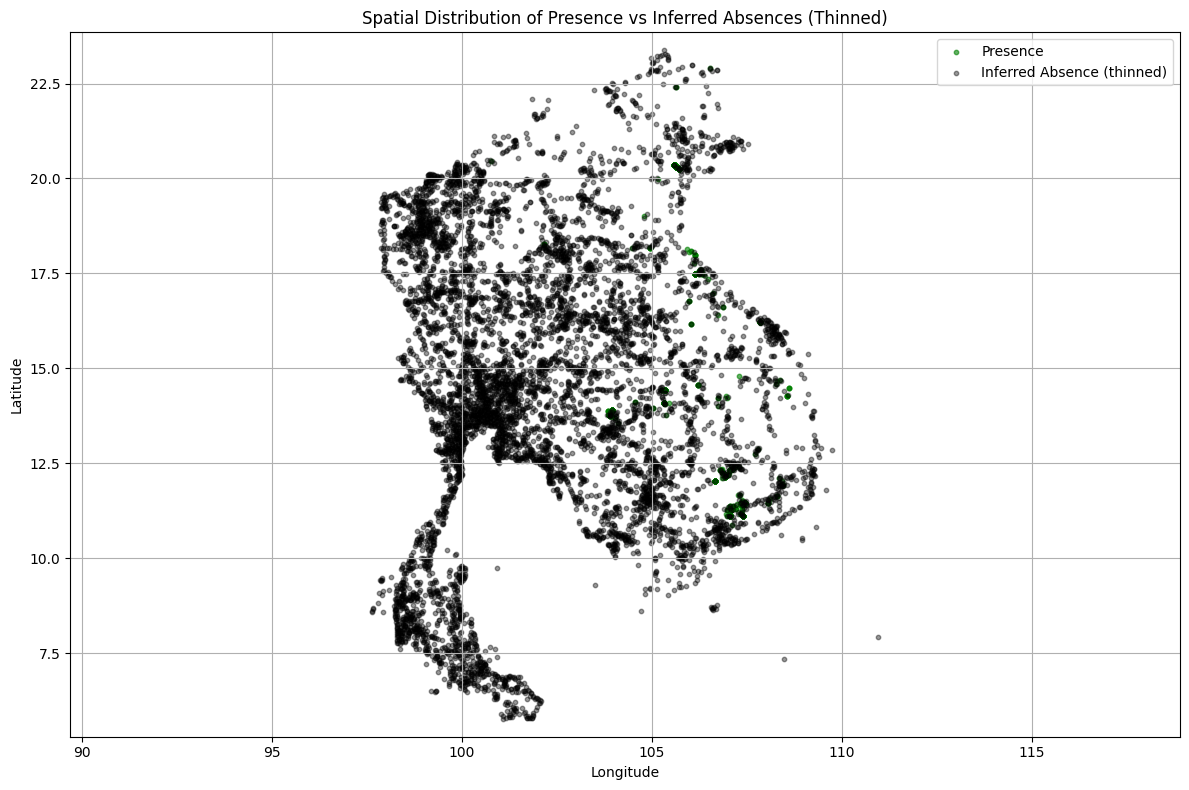

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load presence data
presence = pd.read_csv("/content/drive/My Drive/finaldataset/presence_with_env_vars.csv")

# Load thinned inferred absences
absence = pd.read_csv("/content/drive/My Drive/finaldataset/inferred_absences_thinned.csv")

# Create the map
plt.figure(figsize=(12, 8))

# Plot presence points
plt.scatter(presence['LONGITUDE'], presence['LATITUDE'],
            c='green', label='Presence', s=10, alpha=0.6)

# Plot inferred absences (thinned)
plt.scatter(absence['LONGITUDE'], absence['LATITUDE'],
            c='black', label='Inferred Absence (thinned)', s=10, alpha=0.4)

# Labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Presence vs Inferred Absences (Thinned)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


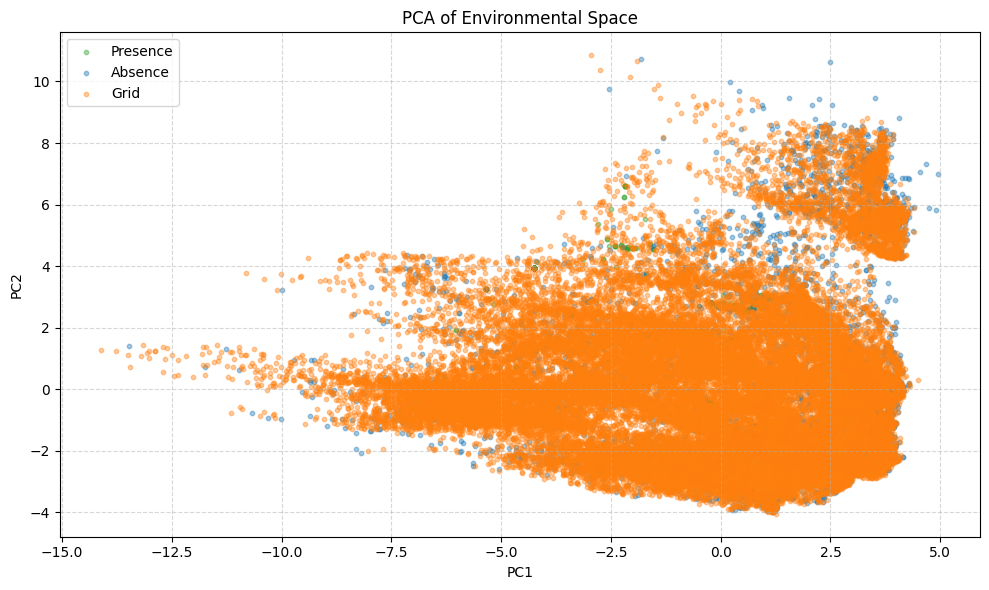

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
presence = pd.read_csv('/content/drive/My Drive/finaldataset/presence_with_env_vars.csv')
absence = pd.read_csv('/content/drive/My Drive/finaldataset/inferred_absences_thinned_with_env_vars_cleaned.csv')
grid = pd.read_csv('/content/drive/My Drive/finaldataset/grid_final_with_env_vars.csv')

# Define environmental variables
env_vars = [col for col in presence.columns if (
    col.startswith('BIO') or col in ['ELEVATION', 'SLOPE', 'ASPECT', 'RUGGEDNESS'] or
    col.startswith('distance_to'))]

# Drop rows with missing values for PCA
presence_clean = presence[env_vars].dropna()
absence_clean = absence[env_vars].dropna()
grid_clean = grid[env_vars].dropna()

# Combine for PCA
combined = pd.concat([presence_clean, absence_clean, grid_clean])
labels = (
    ['Presence'] * len(presence_clean) +
    ['Absence'] * len(absence_clean) +
    ['Grid'] * len(grid_clean)
)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined)

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
colors = {'Presence': '#2ca02c', 'Absence': '#1f77b4', 'Grid': '#ff7f0e'}

for group in ['Presence', 'Absence', 'Grid']:
    idx = [i for i, label in enumerate(labels) if label == group]
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], alpha=0.4, label=group, s=10, c=colors[group])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Environmental Space')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# === Load Presence and Absence Files ===
presence_path = '/content/drive/My Drive/finaldataset/presence_with_env_vars.csv'
absence_path = '/content/drive/My Drive/finaldataset/inferred_absences_thinned_with_env_vars_cleaned.csv'

presence = pd.read_csv(presence_path)
absence = pd.read_csv(absence_path)

# === Add Labels ===
presence['label'] = 1
absence['label'] = 0

# === Combine Datasets ===
combined = pd.concat([presence, absence], ignore_index=True)

# === Drop rows missing lat/lon ===
combined = combined.dropna(subset=['LATITUDE', 'LONGITUDE'])

# === Assign Spatial Blocks ===
# Adjust number of bins depending on resolution you want
lat_bins = pd.cut(combined['LATITUDE'], bins=5)
lon_bins = pd.cut(combined['LONGITUDE'], bins=5)
combined['spatial_block'] = lat_bins.astype(str) + "_" + lon_bins.astype(str)

# === Save Combined Dataset ===
output_path = '/content/drive/My Drive/finaldataset/combined_presence_absence_with_blocks.csv'
combined.to_csv(output_path, index=False)

print(f"✅ Combined dataset with spatial blocks saved to:\n{output_path}")
print(combined[['label', 'LATITUDE', 'LONGITUDE', 'spatial_block']].head())


✅ Combined dataset with spatial blocks saved to:
/content/drive/My Drive/finaldataset/combined_presence_absence_with_blocks.csv
   label   LATITUDE   LONGITUDE                        spatial_block
0      1  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]
1      1  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]
2      1  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]
3      1  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]
4      1  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]


In [ ]:
import pandas as pd

# Load the dataset with spatial blocks
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_presence_absence_with_blocks.csv')

# Count samples per block
block_counts = df['spatial_block'].value_counts().sort_values(ascending=False)

# Display the counts
print("=== Number of Samples per Spatial Block ===")
print(block_counts)


=== Number of Samples per Spatial Block ===
spatial_block
(9.293, 12.813]_(107.087, 109.45]      2311
(12.813, 16.334]_(100.0, 102.362]      1111
(12.813, 16.334]_(102.362, 104.725]     873
(16.334, 19.855]_(97.626, 100.0]        774
(19.855, 23.375]_(104.725, 107.087]     760
(9.293, 12.813]_(104.725, 107.087]      708
(16.334, 19.855]_(102.362, 104.725]     537
(16.334, 19.855]_(100.0, 102.362]       531
(12.813, 16.334]_(97.626, 100.0]        454
(5.754, 9.293]_(97.626, 100.0]          443
(12.813, 16.334]_(104.725, 107.087]     411
(9.293, 12.813]_(102.362, 104.725]      334
(16.334, 19.855]_(104.725, 107.087]     331
(9.293, 12.813]_(97.626, 100.0]         291
(5.754, 9.293]_(100.0, 102.362]         271
(12.813, 16.334]_(107.087, 109.45]      232
(19.855, 23.375]_(100.0, 102.362]       130
(9.293, 12.813]_(100.0, 102.362]        129
(19.855, 23.375]_(102.362, 104.725]     104
(19.855, 23.375]_(97.626, 100.0]         90
(16.334, 19.855]_(107.087, 109.45]       16
(5.754, 9.293]_(10

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupKFold
from collections import defaultdict
import numpy as np

# === Step 1: Load your data ===
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_presence_absence_with_blocks.csv')

# === Step 2: Print sample counts per spatial block ===
block_counts = df['spatial_block'].value_counts()
print("=== Number of Samples per Spatial Block ===")
print(block_counts)

# === Step 3: Select some spatial blocks for a separate test set ===
# Target: 20% of total samples
target_test_size = 0.20 * len(df)

test_blocks = []
accumulated = 0

# Go from smallest blocks upward
for block, count in block_counts[::-1].items():
    test_blocks.append(block)
    accumulated += count
    if accumulated >= target_test_size:
        break

test_set = df[df['spatial_block'].isin(test_blocks)].copy()
train_set = df[~df['spatial_block'].isin(test_blocks)].copy()

print(f"\nTest Set Size: {len(test_set)} (blocks: {test_blocks})")
print(f"Train Set Size: {len(train_set)}")

# === Step 4: Bin spatial blocks into 5 roughly balanced folds ===
n_folds = 5
train_block_counts = train_set['spatial_block'].value_counts().to_dict()
sorted_blocks = sorted(train_block_counts.items(), key=lambda x: x[1], reverse=True)

# Greedy bin-packing: assign each block to fold with currently lowest sample count
fold_bins = defaultdict(list)
fold_sizes = [0] * n_folds

for block, count in sorted_blocks:
    smallest_fold = np.argmin(fold_sizes)
    fold_bins[smallest_fold].append(block)
    fold_sizes[smallest_fold] += count

# === Step 5: Assign fold numbers back to training data ===
def assign_fold(block):
    for fold, blocks in fold_bins.items():
        if block in blocks:
            return fold
    return -1  # shouldn't happen

train_set['cv_fold'] = train_set['spatial_block'].apply(assign_fold)
test_set['cv_fold'] = -1  # test set kept separate

# === Step 6: Combine and save ===
final_df = pd.concat([train_set, test_set], ignore_index=True)
final_df.to_csv('/content/drive/My Drive/finaldataset/combined_presence_absence_with_folds.csv', index=False)
print("\n✅ Fold assignment complete. Saved to: combined_presence_absence_with_folds.csv")

# === Optional: Print fold sizes ===
print("\n=== Training Set Fold Sizes ===")
print(train_set['cv_fold'].value_counts())


=== Number of Samples per Spatial Block ===
spatial_block
(9.293, 12.813]_(107.087, 109.45]      2311
(12.813, 16.334]_(100.0, 102.362]      1111
(12.813, 16.334]_(102.362, 104.725]     873
(16.334, 19.855]_(97.626, 100.0]        774
(19.855, 23.375]_(104.725, 107.087]     760
(9.293, 12.813]_(104.725, 107.087]      708
(16.334, 19.855]_(102.362, 104.725]     537
(16.334, 19.855]_(100.0, 102.362]       531
(12.813, 16.334]_(97.626, 100.0]        454
(5.754, 9.293]_(97.626, 100.0]          443
(12.813, 16.334]_(104.725, 107.087]     411
(9.293, 12.813]_(102.362, 104.725]      334
(16.334, 19.855]_(104.725, 107.087]     331
(9.293, 12.813]_(97.626, 100.0]         291
(5.754, 9.293]_(100.0, 102.362]         271
(12.813, 16.334]_(107.087, 109.45]      232
(19.855, 23.375]_(100.0, 102.362]       130
(9.293, 12.813]_(100.0, 102.362]        129
(19.855, 23.375]_(102.362, 104.725]     104
(19.855, 23.375]_(97.626, 100.0]         90
(16.334, 19.855]_(107.087, 109.45]       16
(5.754, 9.293]_(10

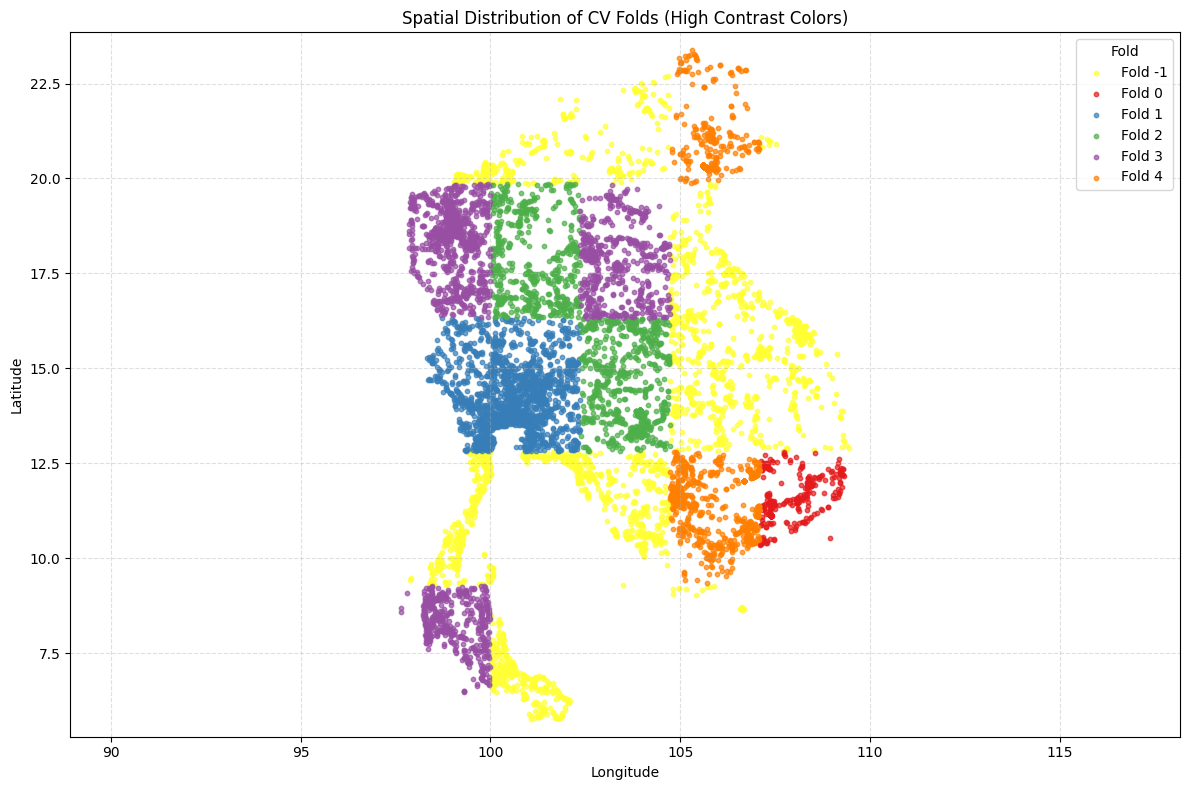

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_presence_absence_with_folds.csv')  # Update if needed

# Custom high-contrast color palette for up to 6 folds
custom_colors = [
    '#e41a1c',  # red
    '#377eb8',  # blue
    '#4daf4a',  # green
    '#984ea3',  # purple
    '#ff7f00',  # orange
    '#ffff33'   # yellow
]

# Plot
plt.figure(figsize=(12, 8))

for fold in sorted(df['cv_fold'].unique()):
    subset = df[df['cv_fold'] == fold]
    plt.scatter(subset['LONGITUDE'], subset['LATITUDE'],
                color=custom_colors[fold % len(custom_colors)],
                label=f'Fold {fold}', s=10, alpha=0.7)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of CV Folds (High Contrast Colors)")
plt.legend(title='Fold')
plt.grid(True, linestyle='--', alpha=0.4)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_presence_absence_with_folds.csv')  # Replace with your file

# Count samples per block
block_counts = df['spatial_block'].value_counts()

# Sort blocks by number of samples (descending)
sorted_blocks = block_counts.index.tolist()

# Number of folds
n_folds = 5

# Distribute blocks to folds while balancing sample count
fold_totals = [0] * n_folds
block_to_fold = {}

for block in sorted_blocks:
    smallest_fold = np.argmin(fold_totals)
    block_to_fold[block] = smallest_fold
    fold_totals[smallest_fold] += block_counts[block]

# Assign folds
df['cv_fold'] = df['spatial_block'].map(block_to_fold)

# Optional: print fold sizes
print("Samples per fold:")
print(df['cv_fold'].value_counts())


Samples per fold:
cv_fold
0    2311
1    2155
3    2149
2    2137
4    2113
Name: count, dtype: int64


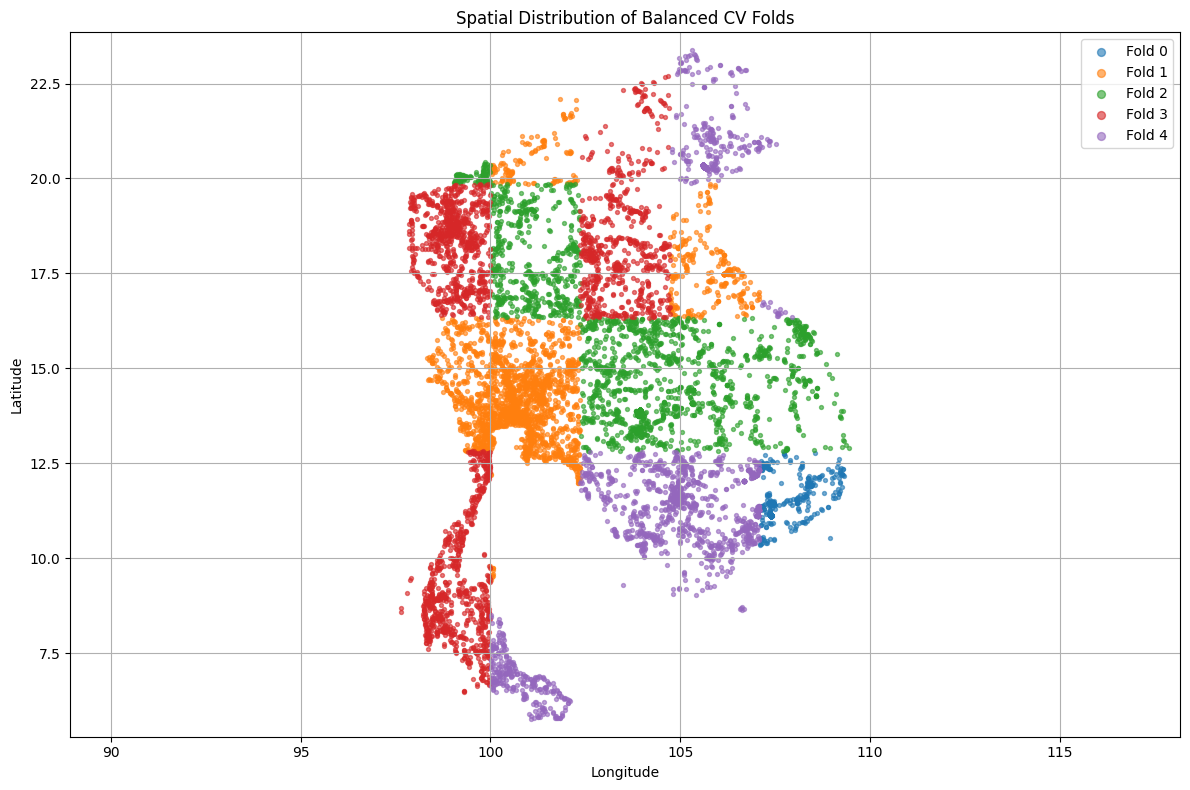

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define distinct colors for folds
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
fold_colors = {fold: colors[i % len(colors)] for i, fold in enumerate(sorted(df['cv_fold'].dropna().unique()))}

# Plot
plt.figure(figsize=(12, 8))
for fold in sorted(df['cv_fold'].unique()):
    subset = df[df['cv_fold'] == fold]
    plt.scatter(subset['LONGITUDE'], subset['LATITUDE'],
                c=fold_colors[fold], label=f'Fold {fold}', s=8, alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Balanced CV Folds")
plt.legend(markerscale=2)
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


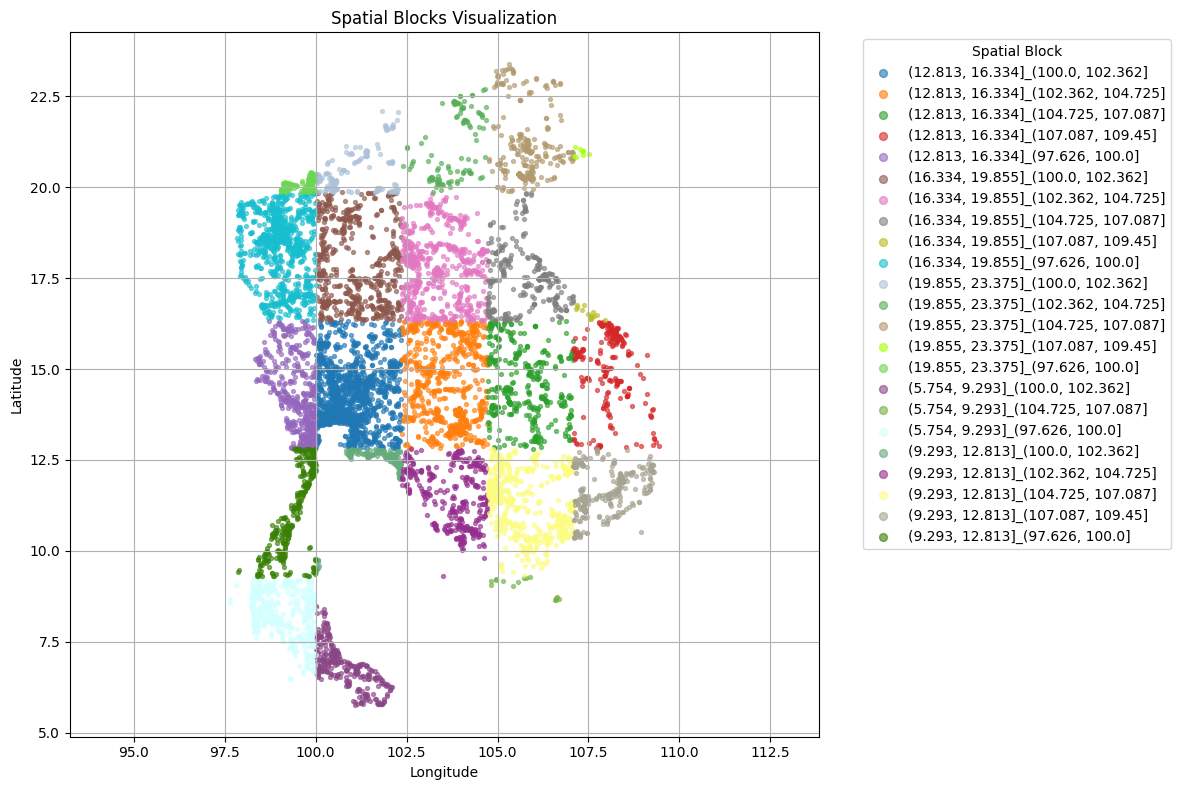

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your dataset
# Replace with your actual CSV if needed
# df = pd.read_csv('/content/your_data.csv')

# Ensure required columns exist
assert {'LATITUDE', 'LONGITUDE', 'spatial_block'}.issubset(df.columns), "Missing required columns"

# Generate distinct colors for each block
unique_blocks = sorted(df['spatial_block'].dropna().unique())
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
block_colors = {block: colors[i % len(colors)] for i, block in enumerate(unique_blocks)}

# Plot
plt.figure(figsize=(12, 8))
for block in unique_blocks:
    subset = df[df['spatial_block'] == block]
    plt.scatter(subset['LONGITUDE'], subset['LATITUDE'],
                c=block_colors[block], label=str(block), s=8, alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Blocks Visualization")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', title='Spatial Block')
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Load your dataset
# df = pd.read_csv('/path/to/your_file.csv')

# 1. Count number of samples per block
block_counts = df['spatial_block'].value_counts().sort_values(ascending=False)
blocks = block_counts.index.tolist()
counts = block_counts.values

# 2. Define test block split (e.g., 20%)
n_test_blocks = int(0.2 * len(blocks))
test_blocks = blocks[:n_test_blocks]  # Top-N blocks (or select by spatial location)
train_blocks = blocks[n_test_blocks:]

# 3. Create stratified folds from train blocks
k = 5  # Number of CV folds
folds = defaultdict(list)
fold_sizes = [0] * k

for block in train_blocks:
    idx = np.argmin(fold_sizes)
    folds[idx].append(block)
    fold_sizes[idx] += block_counts[block]

# 4. Assign fold labels to samples
def assign_fold(row):
    if row['spatial_block'] in test_blocks:
        return 'test'
    for fold_id, blocks_in_fold in folds.items():
        if row['spatial_block'] in blocks_in_fold:
            return fold_id
    return np.nan

df['cv_fold'] = df.apply(assign_fold, axis=1)

# 5. Show summary
print("=== Fold Sizes ===")
print(df['cv_fold'].value_counts())


=== Fold Sizes ===
cv_fold
test    5069
1       1168
3       1162
2       1157
0       1155
4       1154
Name: count, dtype: int64


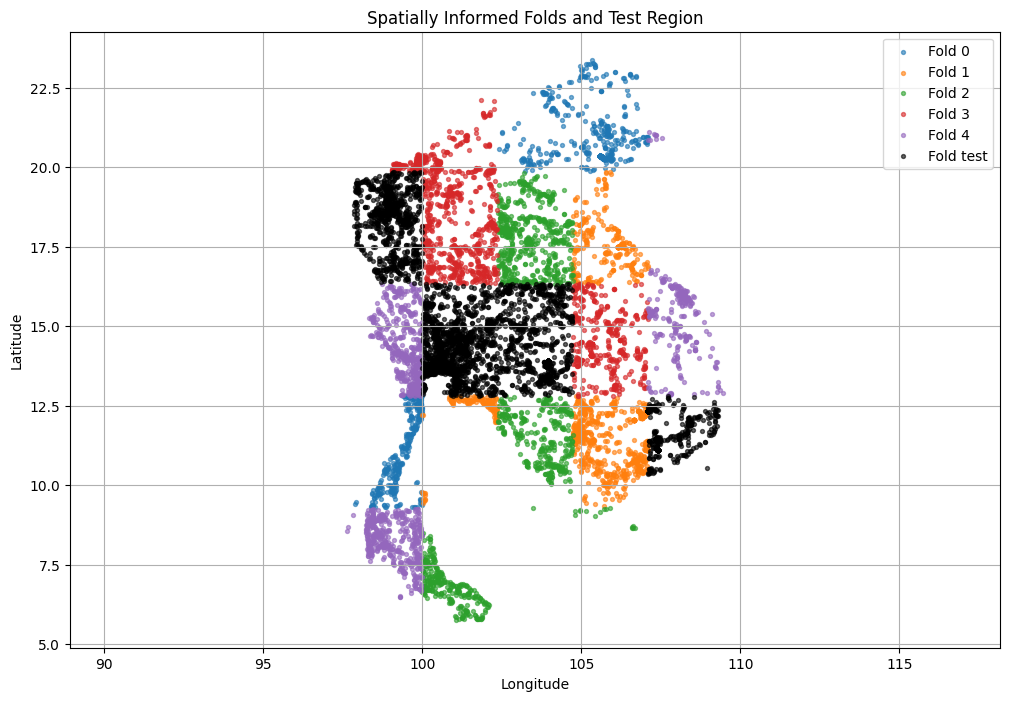

In [ ]:
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'black']
labels = sorted(df['cv_fold'].dropna().unique(), key=lambda x: str(x))

plt.figure(figsize=(12, 8))
for label in labels:
    subset = df[df['cv_fold'] == label]
    plt.scatter(subset['LONGITUDE'], subset['LATITUDE'], s=8, alpha=0.6,
                label=f'Fold {label}', c=colors[int(label)] if str(label).isdigit() else 'black')

plt.legend()
plt.title("Spatially Informed Folds and Test Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.axis('equal')
plt.show()


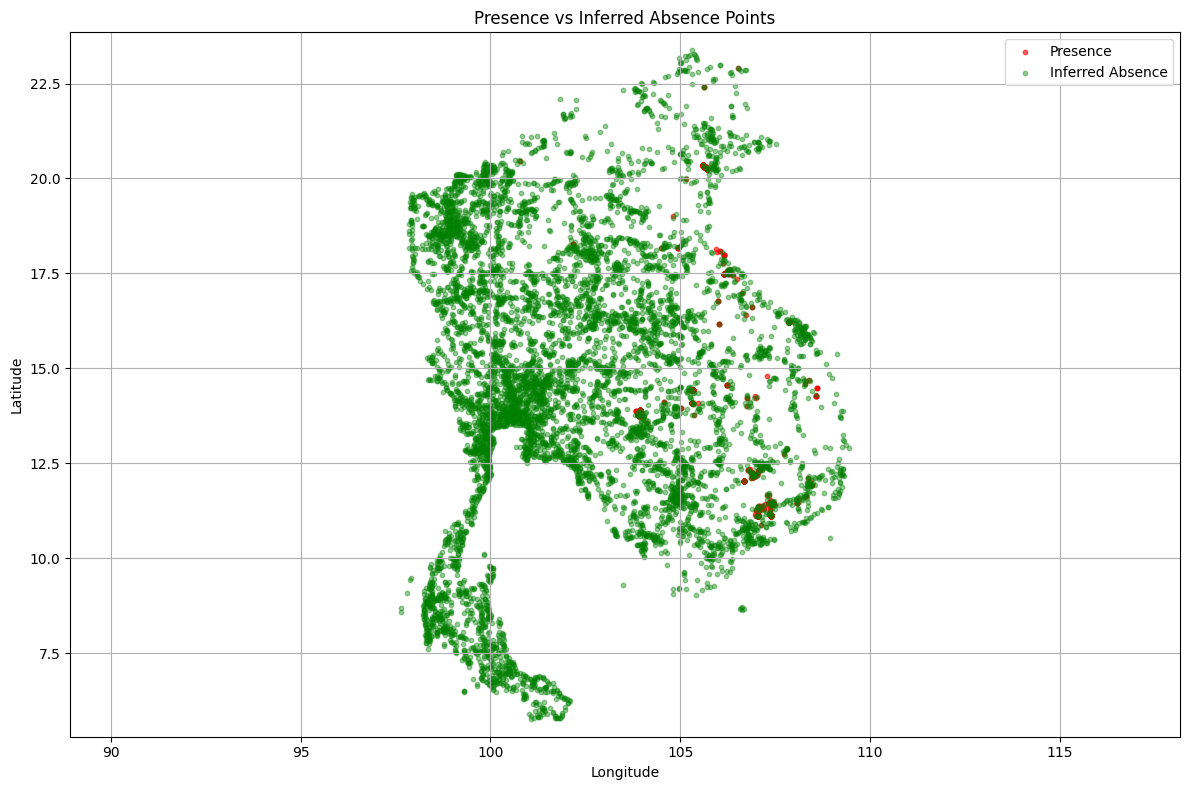

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load presence and absence data
presence_df = pd.read_csv('/content/drive/My Drive/finaldataset/presence_with_env_vars.csv')
absence_df = pd.read_csv('/content/drive/My Drive/finaldataset/inferred_absences_thinned_with_env_vars_cleaned.csv')

# Plot
plt.figure(figsize=(12, 8))

# Plot presence points
plt.scatter(presence_df['LONGITUDE'], presence_df['LATITUDE'],
            c='red', label='Presence', alpha=0.6, s=10)

# Plot absence points
plt.scatter(absence_df['LONGITUDE'], absence_df['LATITUDE'],
            c='green', label='Inferred Absence', alpha=0.4, s=10)

# Styling
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Presence vs Inferred Absence Points')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Paths to your files
presence_path = '/content/drive/My Drive/finaldataset/presence_with_env_vars.csv'
absence_path = '/content/drive/My Drive/finaldataset/inferred_absences_thinned_with_env_vars.csv'

# Load just the headers
presence_columns = pd.read_csv(presence_path, nrows=0).columns
absence_columns = pd.read_csv(absence_path, nrows=0).columns

# Print columns
print("📌 Presence file columns:")
print(presence_columns)

print("\n📌 Inferred absence file columns:")
print(absence_columns)


📌 Presence file columns:
Index(['GLOBAL UNIQUE IDENTIFIER', 'LAST EDITED DATE', 'TAXONOMIC ORDER',
       'CATEGORY', 'TAXON CONCEPT ID', 'COMMON NAME', 'SCIENTIFIC NAME',
       'SUBSPECIES COMMON NAME', 'SUBSPECIES SCIENTIFIC NAME', 'EXOTIC CODE',
       'OBSERVATION COUNT', 'BREEDING CODE', 'BREEDING CATEGORY',
       'BEHAVIOR CODE', 'AGE/SEX', 'COUNTRY', 'COUNTRY CODE', 'STATE',
       'STATE CODE', 'COUNTY', 'COUNTY CODE', 'IBA CODE', 'BCR CODE',
       'USFWS CODE', 'ATLAS BLOCK', 'LOCALITY', 'LOCALITY ID', 'LOCALITY TYPE',
       'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
       'TIME OBSERVATIONS STARTED', 'OBSERVER ID', 'OBSERVER ORCID ID',
       'SAMPLING EVENT IDENTIFIER', 'OBSERVATION TYPE', 'PROTOCOL NAME',
       'PROTOCOL CODE', 'PROJECT NAMES', 'PROJECT IDENTIFIERS',
       'DURATION MINUTES', 'EFFORT DISTANCE KM', 'EFFORT AREA HA',
       'NUMBER OBSERVERS', 'ALL SPECIES REPORTED', 'GROUP IDENTIFIER',
       'HAS MEDIA', 'APPROVED', 'REVIEWED', 'REASON', 'CHECKLIST

In [ ]:
import pandas as pd

# Load files
presence_path = '/content/drive/My Drive/finaldataset/presence_with_env_vars.csv'
absence_path = '/content/drive/My Drive/finaldataset/inferred_absences_thinned_with_env_vars.csv'

presence_df = pd.read_csv(presence_path)
absence_df = pd.read_csv(absence_path)

# Combine presence and absence
combined_df = pd.concat([presence_df, absence_df], ignore_index=True)

# Print class distribution
print("✅ Class distribution:")
print(combined_df['RECORD TYPE'].value_counts())

# Save
output_path = '/content/drive/My Drive/finaldataset/combined_presence_absence.csv'
combined_df.to_csv(output_path, index=False)
print(f"\n✅ Saved merged dataset to:\n{output_path}")


✅ Class distribution:
RECORD TYPE
inferred absence    7828
presence            3293
Name: count, dtype: int64

✅ Saved merged dataset to:
/content/drive/My Drive/finaldataset/combined_presence_absence.csv


In [ ]:
import pandas as pd

# Load presence and inferred absence datasets
presence = pd.read_csv('/content/drive/My Drive/finaldataset/presence_with_env_vars.csv')
absence = pd.read_csv('/content/drive/My Drive/finaldataset/inferred_absences_thinned_with_env_vars_cleaned.csv')

# Ensure the RECORD TYPE column exists and is properly set
presence['RECORD TYPE'] = 'presence'
absence['RECORD TYPE'] = 'absence'

# Combine
combined = pd.concat([presence, absence], ignore_index=True)

# Save
combined.to_csv('/content/drive/My Drive/finaldataset/combined_presence_absence.csv', index=False)
print("✅ Combined file saved.")


✅ Combined file saved.


In [ ]:
import pandas as pd
from sklearn.utils import shuffle

# Load the combined dataset
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_presence_absence.csv')

# Check existing blocks
print("🧩 Number of samples per spatial block:")
print(df['spatial_block'].value_counts())

# Define the blocks you want to reserve for test set
test_blocks = [
    # Use actual string labels from your data (use `df['spatial_block'].unique()` to see them if needed)
    '(19.855, 23.375]_(102.362, 104.725]',
    '(19.855, 23.375]_(104.725, 107.087]',
    '(19.855, 23.375]_(107.087, 109.45]'
]

# All other blocks
all_blocks = df['spatial_block'].dropna().unique().tolist()
trainval_blocks = [b for b in all_blocks if b not in test_blocks]

# Shuffle for randomness
trainval_blocks = shuffle(trainval_blocks, random_state=42)

# Assign 5 folds as evenly as possible
num_folds = 5
fold_assignments = {}
for i, block in enumerate(trainval_blocks):
    fold_assignments[block] = i % num_folds  # assign round-robin to folds

# Apply fold assignment
def assign_fold(row):
    if row['spatial_block'] in test_blocks:
        return 'test'
    return fold_assignments.get(row['spatial_block'], 'unassigned')

df['fold'] = df.apply(assign_fold, axis=1)

# ✅ Save updated file
df.to_csv('/content/drive/My Drive/finaldataset/combined_with_folds.csv', index=False)
print("✅ Folds and test region assigned and saved.")


🧩 Number of samples per spatial block:


KeyError: 'spatial_block'

In [ ]:
import pandas as pd

# Load the combined dataset
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_presence_absence.csv')

# Define number of bins for spatial blocking
n_lat_bins = 5
n_lon_bins = 5

# Create bins
df['lat_bin'] = pd.cut(df['LATITUDE'], bins=n_lat_bins)
df['lon_bin'] = pd.cut(df['LONGITUDE'], bins=n_lon_bins)

# Create combined spatial block label
df['spatial_block'] = df['lat_bin'].astype(str) + '_' + df['lon_bin'].astype(str)

# Preview and check
print("✅ Added spatial blocks. Sample:")
print(df[['LATITUDE', 'LONGITUDE', 'spatial_block']].head())

# Save with spatial block column
df.to_csv('/content/drive/My Drive/finaldataset/combined_presence_absence_with_blocks.csv', index=False)


✅ Added spatial blocks. Sample:
    LATITUDE   LONGITUDE                        spatial_block
0  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]
1  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]
2  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]
3  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]
4  14.441578  105.344623  (12.813, 16.334]_(104.725, 107.087]


In [ ]:
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_presence_absence_with_blocks.csv')


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Load data with spatial blocks
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_presence_absence_with_blocks.csv')

# === Step 1: Choose blocks for test set ===
# You can customize this list
test_blocks = [
    '(9.293, 12.813]_(107.087, 109.45]',
    '(12.813, 16.334]_(107.087, 109.45]',
    '(16.334, 19.855]_(107.087, 109.45]',
    '(19.855, 23.375]_(107.087, 109.45]'
]

# Tag rows as test or not
df['cv_group'] = 'train'  # Default
df.loc[df['spatial_block'].isin(test_blocks), 'cv_group'] = 'test'

# === Step 2: Assign folds only to training blocks ===
train_blocks = df[df['cv_group'] == 'train']['spatial_block'].unique()
block_counts = df[df['cv_group'] == 'train']['spatial_block'].value_counts().to_dict()

# Sort blocks by count (descending) for balanced assignment
sorted_blocks = sorted(train_blocks, key=lambda b: -block_counts[b])

# Create empty fold groups
n_folds = 5
fold_bins = defaultdict(list)
fold_totals = [0] * n_folds

# Greedy assignment to balance total samples across folds
for block in sorted_blocks:
    smallest_fold = np.argmin(fold_totals)
    fold_bins[smallest_fold].append(block)
    fold_totals[smallest_fold] += block_counts[block]

# Assign fold number to each row
df['cv_fold'] = np.nan
for fold, blocks in fold_bins.items():
    df.loc[df['spatial_block'].isin(blocks), 'cv_fold'] = fold

# Save the new file
output_path = '/content/drive/My Drive/finaldataset/combined_with_spatial_folds.csv'
df.to_csv(output_path, index=False)
print(f"✅ Saved file with CV folds and test set: {output_path}")

# Preview
print("\nFold assignment summary:")
print(df['cv_fold'].value_counts(dropna=False))
print("\nTest set sample count:", (df['cv_group'] == 'test').sum())


✅ Saved file with CV folds and test set: /content/drive/My Drive/finaldataset/combined_with_spatial_folds.csv

Fold assignment summary:
cv_fold
NaN    2568
2.0    1691
4.0    1680
3.0    1672
0.0    1652
1.0    1602
Name: count, dtype: int64

Test set sample count: 2568


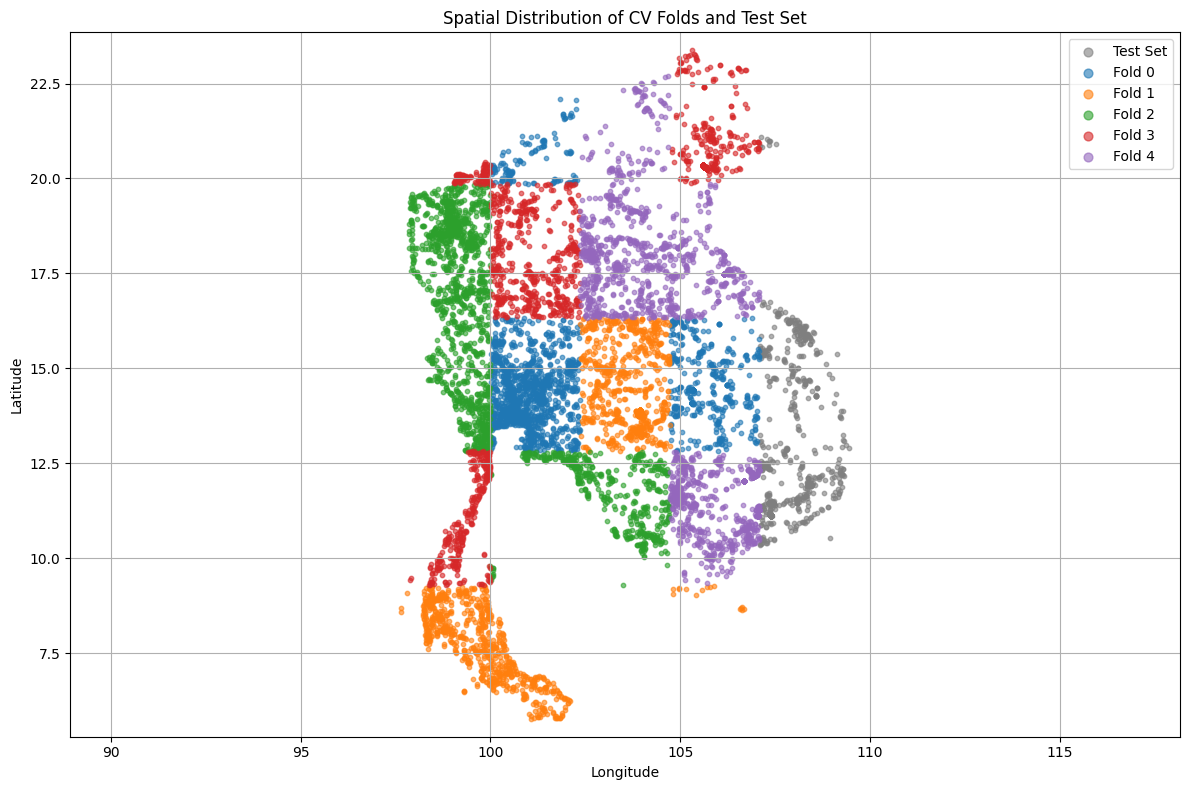

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your combined dataset with folds
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_with_spatial_folds.csv')

# Prepare colors for up to 6 groups (folds 0–4 + test)
colors = {
    0: '#1f77b4',  # blue
    1: '#ff7f0e',  # orange
    2: '#2ca02c',  # green
    3: '#d62728',  # red
    4: '#9467bd',  # purple
    'test': '#7f7f7f'  # gray
}

# Create a plot
plt.figure(figsize=(12, 8))

# Plot test set separately
test_set = df[df['cv_group'] == 'test']
plt.scatter(test_set['LONGITUDE'], test_set['LATITUDE'],
            c=colors['test'], label='Test Set', s=10, alpha=0.6)

# Plot each fold
for fold in range(5):
    subset = df[(df['cv_fold'] == fold) & (df['cv_group'] == 'train')]
    plt.scatter(subset['LONGITUDE'], subset['LATITUDE'],
                c=colors[fold], label=f'Fold {fold}', s=10, alpha=0.6)

# Final touches
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of CV Folds and Test Set')
plt.legend(markerscale=2)
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


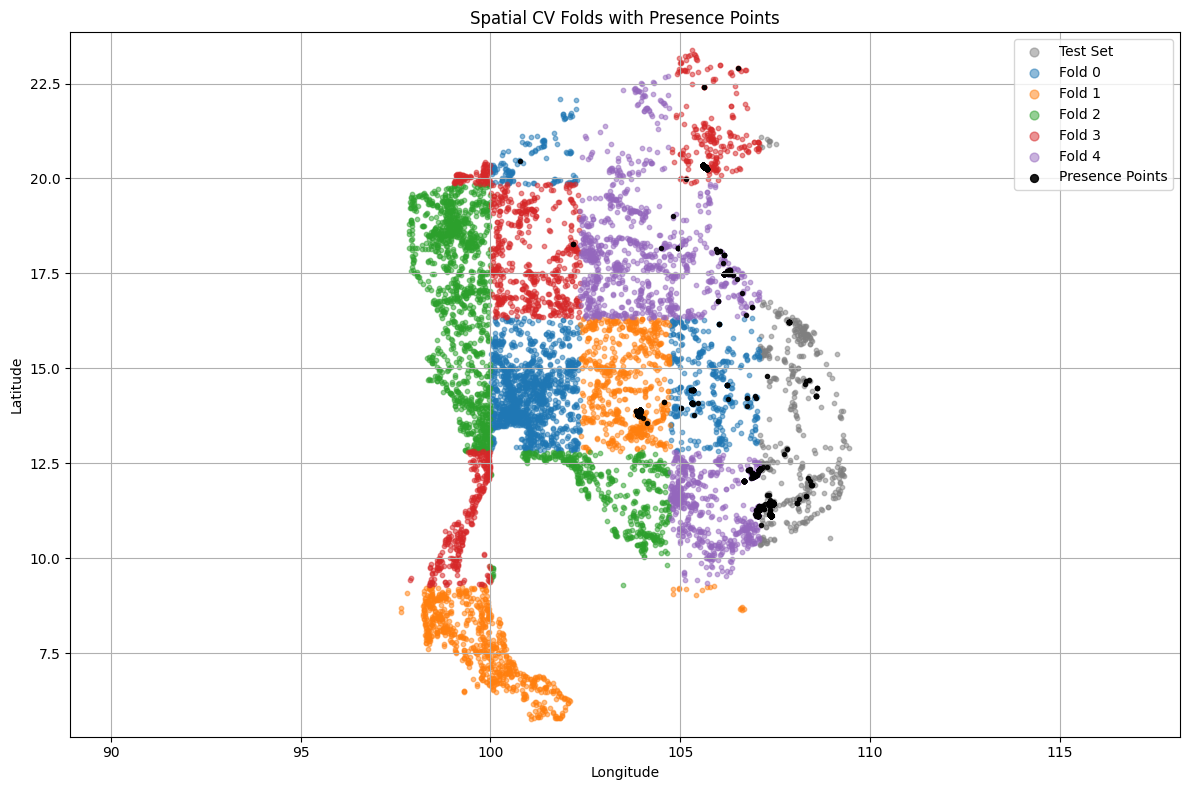

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load combined dataset with folds
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_with_spatial_folds.csv')

# Load presence points (with same structure and env vars)
presence = pd.read_csv('/content/drive/My Drive/finaldataset/presence_with_env_vars.csv')

# Prepare colors for folds and test
colors = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: '#2ca02c',
    3: '#d62728',
    4: '#9467bd',
    'test': '#7f7f7f'
}

# Plot all points
plt.figure(figsize=(12, 8))

# Test set (gray)
test_set = df[df['cv_group'] == 'test']
plt.scatter(test_set['LONGITUDE'], test_set['LATITUDE'],
            c=colors['test'], label='Test Set', s=10, alpha=0.5)

# Training folds
for fold in range(5):
    fold_data = df[(df['cv_fold'] == fold) & (df['cv_group'] == 'train')]
    plt.scatter(fold_data['LONGITUDE'], fold_data['LATITUDE'],
                c=colors[fold], label=f'Fold {fold}', s=10, alpha=0.5)

# Overlay presence points (black)
plt.scatter(presence['LONGITUDE'], presence['LATITUDE'],
            c='black', label='Presence Points', s=8, alpha=0.9)

# Labels and layout
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial CV Folds with Presence Points")
plt.legend(markerscale=2)
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# === Load data ===
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_with_spatial_folds.csv')

# ✅ Make sure 'label' exists
if 'label' not in df.columns:
    df['label'] = df['RECORD TYPE'].apply(lambda x: 1 if str(x).lower() == 'presence' else 0)

# === Define environmental variables ===
env_vars = [col for col in df.columns if (
    col.startswith('BIO') or
    col in ['ELEVATION', 'SLOPE', 'ASPECT', 'RUGGEDNESS'] or
    col.startswith('distance_to'))]

# === Determine valid folds (must contain ≥1 presence) ===
fold_stats = df[df['cv_group'] == 'train'].groupby('cv_fold')['label'].value_counts().unstack().fillna(0)
fold_stats['presence_count'] = fold_stats.get(1.0, 0).astype(int)
valid_folds = fold_stats[fold_stats['presence_count'] > 0].index.astype(int).tolist()

# Print fold presence summary
print("📊 Presence Count Per Fold:")
print(fold_stats[['presence_count']].loc[valid_folds])

# === Train and evaluate ===
results = []

for fold in valid_folds:
    print(f"\n🔁 Training fold {fold}...")

    train_df = df[(df['cv_group'] == 'train') & (df['cv_fold'] != fold)]
    val_df = df[(df['cv_group'] == 'train') & (df['cv_fold'] == fold)]

    # Drop rows with missing data
    X_train = train_df[env_vars].dropna()
    y_train = train_df.loc[X_train.index, 'label']

    X_val = val_df[env_vars].dropna()
    y_val = val_df.loc[X_val.index, 'label']

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_scaled, y_train)

    # Predict
    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    y_pred = model.predict(X_val_scaled)

    # Evaluate
    auc = roc_auc_score(y_val, y_proba) if len(np.unique(y_val)) > 1 else np.nan
    acc = accuracy_score(y_val, y_pred)

    results.append({'fold': fold, 'AUC': auc, 'Accuracy': acc, 'Presence_Count': int(fold_stats.loc[fold]['presence_count'])})
    print(f"✅ Fold {fold}: AUC = {auc:.3f}, Accuracy = {acc:.3f}, Presence Points = {int(fold_stats.loc[fold]['presence_count'])}")

# === Show results ===
results_df = pd.DataFrame(results)
print("\n📊 Fold-wise Performance Summary:")
print(results_df)

print(f"\n📈 Mean AUC: {results_df['AUC'].mean():.3f}")
print(f"📈 Mean Accuracy: {results_df['Accuracy'].mean():.3f}")


📊 Presence Count Per Fold:
label    presence_count
cv_fold                
0.0                  69
1.0                 247
3.0                 548
4.0                 312

🔁 Training fold 0...
✅ Fold 0: AUC = 0.886, Accuracy = 0.958, Presence Points = 69

🔁 Training fold 1...
✅ Fold 1: AUC = 0.779, Accuracy = 0.839, Presence Points = 247

🔁 Training fold 3...
✅ Fold 3: AUC = 0.975, Accuracy = 0.663, Presence Points = 548

🔁 Training fold 4...
✅ Fold 4: AUC = 0.551, Accuracy = 0.811, Presence Points = 312

📊 Fold-wise Performance Summary:
   fold       AUC  Accuracy  Presence_Count
0     0  0.885783  0.957580              69
1     1  0.779377  0.838668             247
2     3  0.975181  0.663015             548
3     4  0.551411  0.811118             312

📈 Mean AUC: 0.798
📈 Mean Accuracy: 0.818


In [8]:
print(df[df['cv_group'] == 'train'].groupby('cv_fold')['label'].value_counts().unstack(fill_value=0))


label       0    1
cv_fold           
0.0      1583   69
1.0      1355  247
2.0      1691    0
3.0      1124  548
4.0      1368  312


In [9]:
# === Step 1: Prepare train and test sets ===
train_df = df[df['cv_group'] == 'train']
test_df = df[df['cv_group'] == 'test']

# Drop rows with missing values
X_train = train_df[env_vars].dropna()
y_train = train_df.loc[X_train.index, 'label']

X_test = test_df[env_vars].dropna()
y_test = test_df.loc[X_test.index, 'label']

# === Step 2: Train model ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# === Step 3: Predict ===
test_df = test_df.loc[X_test.index].copy()
test_df['pred_prob'] = model.predict_proba(X_test_scaled)[:, 1]
test_df['pred_label'] = model.predict(X_test_scaled)

# === Step 4: Evaluate ===
from sklearn.metrics import roc_auc_score, accuracy_score

auc = roc_auc_score(y_test, test_df['pred_prob']) if len(np.unique(y_test)) > 1 else np.nan
acc = accuracy_score(y_test, test_df['pred_label'])

print(f"📊 Test Set AUC: {auc:.3f}")
print(f"📊 Test Set Accuracy: {acc:.3f}")


📊 Test Set AUC: 0.953
📊 Test Set Accuracy: 0.171


In [10]:
test_df.to_csv('/content/drive/My Drive/finaldataset/test_predictions.csv', index=False)
print("✅ Saved predictions to test_predictions.csv")


✅ Saved predictions to test_predictions.csv


In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Load grid and training data
grid = pd.read_csv('/content/drive/My Drive/finaldataset/grid_final_with_env_vars.csv')
train_df = df[df['cv_group'] == 'train']

# Drop NAs from train
X_train = train_df[env_vars].dropna()
y_train = train_df.loc[X_train.index, 'label']

# Drop NAs from grid
grid_clean = grid[env_vars].dropna()
grid_coords = grid.loc[grid_clean.index, ['LATITUDE', 'LONGITUDE']]

# Train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_grid_scaled = scaler.transform(grid_clean)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Predict
grid_pred = model.predict_proba(X_grid_scaled)[:, 1]
grid_result = grid_coords.copy()
grid_result['pred_prob'] = grid_pred


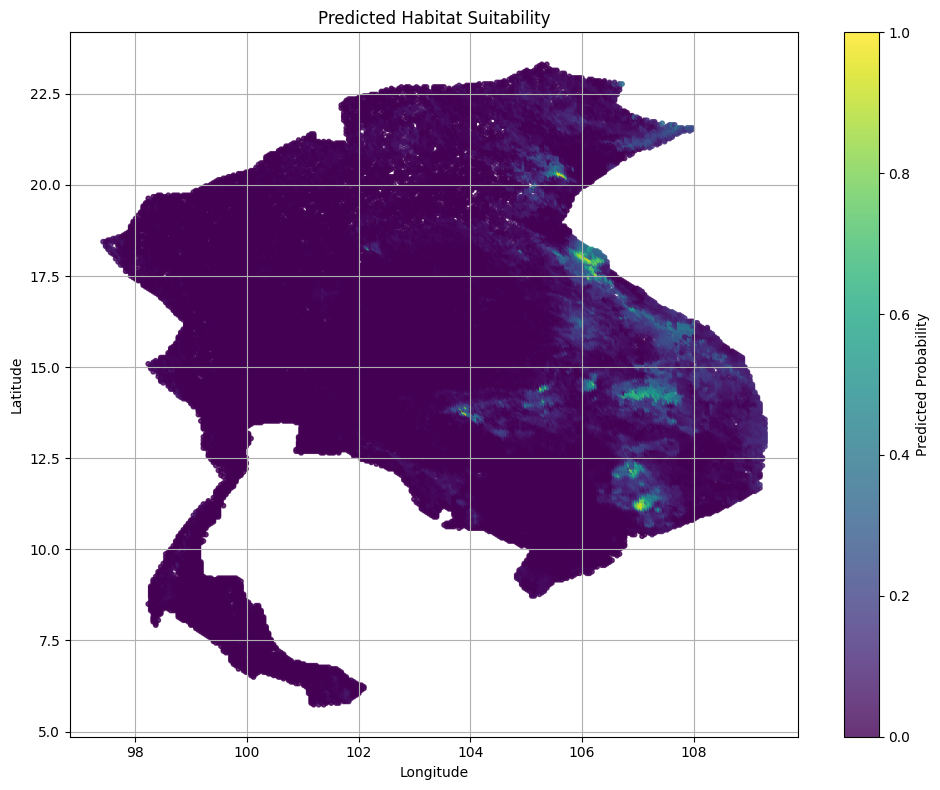

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sc = plt.scatter(grid_result['LONGITUDE'], grid_result['LATITUDE'],
                 c=grid_result['pred_prob'], cmap='viridis', s=10, alpha=0.8)
plt.colorbar(sc, label='Predicted Probability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Habitat Suitability')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# === Load training data (filtered) ===
df = pd.read_csv('/content/drive/My Drive/finaldataset/filtered_cv_folds.csv')
df['label'] = df['RECORD TYPE'].apply(lambda x: 1 if str(x).lower() == 'presence' else 0)

# === Load grid data ===
grid_df = pd.read_csv('/content/drive/My Drive/finaldataset/grid_final_with_env_vars.csv')

# === Define environmental variables ===
env_vars = [col for col in df.columns if (
    col.startswith('BIO') or
    col in ['ELEVATION', 'SLOPE', 'ASPECT', 'RUGGEDNESS'] or
    col.startswith('distance_to'))]

# === Prepare training data ===
X_train = df[env_vars].dropna()
y_train = df.loc[X_train.index, 'label']

# === Prepare grid data ===
grid_data = grid_df[env_vars].dropna()
grid_meta = grid_df.loc[grid_data.index, ['LATITUDE', 'LONGITUDE']]  # Save location info

# === Train final model ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
grid_scaled = scaler.transform(grid_data)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# === Predict on grid ===
grid_df.loc[grid_data.index, 'pred_prob'] = model.predict_proba(grid_scaled)[:, 1]

# === Save predictions ===
grid_df.to_csv('/content/drive/My Drive/finaldataset/grid_predictions.csv', index=False)
print("✅ Saved prediction results to: /content/drive/My Drive/finaldataset/grid_predictions.csv")


<ipython-input-6-3315d7e8067a>:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/finaldataset/filtered_cv_folds.csv')


✅ Saved prediction results to: /content/drive/My Drive/finaldataset/grid_predictions.csv


In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score, accuracy_score

# Load grid predictions
grid_result = pd.read_csv('/content/drive/My Drive/finaldataset/grid_predictions.csv')

# Load spatial fold assignments
cv_info = pd.read_csv('/content/drive/My Drive/finaldataset/filtered_cv_folds.csv')  # Contains 'cv_group', 'spatial_block'

# Merge to get fold info into prediction grid
if 'spatial_block' not in grid_result.columns:
    grid_result['lat_bin'] = pd.cut(grid_result['LATITUDE'], bins=5)
    grid_result['lon_bin'] = pd.cut(grid_result['LONGITUDE'], bins=5)
    grid_result['spatial_block'] = grid_result['lat_bin'].astype(str) + "_" + grid_result['lon_bin'].astype(str)

grid_result = grid_result.merge(cv_info[['LATITUDE', 'LONGITUDE', 'spatial_block', 'cv_group', 'RECORD TYPE']],
                                on=['LATITUDE', 'LONGITUDE'], how='left')

# Convert to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(
    grid_result,
    geometry=gpd.points_from_xy(grid_result['LONGITUDE'], grid_result['LATITUDE']),
    crs='EPSG:4326'
)

# Load presence points
presence = pd.read_csv('/content/drive/My Drive/finaldataset/presence_with_env_vars.csv')
presence_gdf = gpd.GeoDataFrame(
    presence,
    geometry=gpd.points_from_xy(presence['LONGITUDE'], presence['LATITUDE']),
    crs='EPSG:4326'
)

# Identify test blocks
test_blocks = grid_gdf[grid_gdf['cv_group'] == 'test']['spatial_block'].unique()

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 10))

# Prediction heatmap
grid_gdf.plot(ax=ax, column='pred_prob', cmap='viridis', legend=True,
              markersize=10, alpha=0.6)

# Overlay rectangles for spatial blocks (red if test block)
for block, block_data in grid_gdf.groupby('spatial_block'):
    minx, miny, maxx, maxy = block_data.total_bounds
    is_test = block in test_blocks
    rect = mpatches.Rectangle(
        (minx, miny), maxx - minx, maxy - miny,
        fill=False,
        edgecolor='red' if is_test else 'black',
        linewidth=1.2 if is_test else 0.5
    )
    ax.add_patch(rect)

# Overlay presence points
presence_gdf.plot(ax=ax, color='black', markersize=12, label='Presence')

# Labels and layout
ax.set_title('Prediction Heatmap with Spatial Blocks and Test Region Highlighted')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Test Set Performance ===
test_df = grid_gdf[grid_gdf['cv_group'] == 'test'].copy()
test_df['label'] = test_df['RECORD TYPE'].apply(lambda x: 1 if str(x).lower() == 'presence' else 0)

if test_df['label'].nunique() == 2:
    auc = roc_auc_score(test_df['label'], test_df['pred_prob'])
    acc = accuracy_score(test_df['label'], test_df['pred_prob'] > 0.5)
    print(f"\n🧪 Test Set Performance:")
    print(f"AUC: {auc:.3f}")
    print(f"Accuracy: {acc:.3f}")
else:
    print("\n⚠️ Test set does not contain both classes. AUC cannot be computed.")


<ipython-input-8-47371abf1892>:11: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  cv_info = pd.read_csv('/content/drive/My Drive/finaldataset/filtered_cv_folds.csv')  # Contains 'cv_group', 'spatial_block'


KeyError: 'spatial_block'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('/content/drive/My Drive/finaldataset/combined_with_spatial_folds.csv')

# Define environmental variables
env_vars = [col for col in df.columns if (
    col.startswith('BIO') or col in ['ELEVATION', 'SLOPE', 'ASPECT', 'RUGGEDNESS'] or
    col.startswith('distance_to'))]

# Drop missing
df = df.dropna(subset=env_vars + ['RECORD TYPE'])

# Label: presence = 1, absence = 0
df['label'] = (df['RECORD TYPE'] == 'presence').astype(int)

# Only use rows in the training CV folds (not test set)
cv_data = df[df['cv_group'] == 'train'].copy()

# Placeholder for metrics
fold_metrics = []

# Loop through 5 folds
for fold in sorted(cv_data['cv_fold'].dropna().unique()):
    train_data = cv_data[cv_data['cv_fold'] != fold]
    val_data = cv_data[cv_data['cv_fold'] == fold]

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_data[env_vars])
    X_val = scaler.transform(val_data[env_vars])
    y_train = train_data['label']
    y_val = val_data['label']

    # Model
    model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    acc = accuracy_score(y_val, y_pred)

    fold_metrics.append({'fold': fold, 'AUC': auc, 'Accuracy': acc})

# Results
cv_results = pd.DataFrame(fold_metrics)
print("📊 Spatial CV Performance:")
print(cv_results)
print(f"\nMean AUC: {cv_results['AUC'].mean():.3f}")
print(f"Mean Accuracy: {cv_results['Accuracy'].mean():.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


📊 Spatial CV Performance:
   fold       AUC  Accuracy
0   0.0  0.925987  0.957580
1   1.0  0.783599  0.838668
2   2.0       NaN  1.000000
3   3.0  0.978757  0.663015
4   4.0  0.532581  0.811118

Mean AUC: 0.805
Mean Accuracy: 0.854


In [ ]:
# Print class balance per fold
cv_data = df[df['cv_group'] == 'train'].copy()
summary = cv_data.groupby('cv_fold')['label'].value_counts().unstack(fill_value=0)
summary.columns = ['Absence (0)', 'Presence (1)']
summary['Total'] = summary.sum(axis=1)
summary['% Presence'] = 100 * summary['Presence (1)'] / summary['Total']
print("📊 Label Distribution per Fold:")
print(summary)


📊 Label Distribution per Fold:
         Absence (0)  Presence (1)  Total  % Presence
cv_fold                                              
0.0             1535            68   1603    4.242046
1.0             1284           247   1531   16.133246
2.0             1581             0   1581    0.000000
3.0             1029           523   1552   33.698454
4.0             1284           299   1583   18.888187


In [ ]:
import pandas as pd

# Load your file with folds
df = pd.read_csv("/content/drive/My Drive/finaldataset/combined_with_rebalanced_spatial_folds.csv")

# Add label column if needed
if 'label' not in df.columns:
    df['label'] = df['RECORD TYPE'].map({'presence': 1, 'absence': 0})

# Identify folds that contain at least one presence
presence_per_fold = df[df['label'] == 1].groupby('cv_fold').size()
valid_folds = presence_per_fold[presence_per_fold > 0].index.tolist()

# Filter to only folds with presence data
df_filtered = df[df['cv_fold'].isin(valid_folds)]

# Save filtered file
out_path = "/content/drive/My Drive/finaldataset/filtered_cv_folds.csv"
df_filtered.to_csv(out_path, index=False)

print(f"✅ Filtered dataset saved: {out_path}")
print(f"📉 Dropped folds with no presence. Remaining folds: {sorted(valid_folds)}")


✅ Filtered dataset saved: /content/drive/My Drive/finaldataset/filtered_cv_folds.csv
📉 Dropped folds with no presence. Remaining folds: [0, 1, 2, 4]
